# Large scale text analysis with deep learning (3 points)

Today we're gonna apply the newly learned tools for the task of predicting job salary.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

_Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the core assignment idea._

In [84]:
!ipython nbconvert --to html Lab_1_NLP.ipynb

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] Converting notebook Lab_1_NLP.ipynb to html
[NbConvertApp] Writing 1124769 bytes to Lab_1_NLP.html


## *Резюме: что было сделано в ноутбуке.*

*Доработки вне основных заданий*
* Обновлена функция tokenizer(), повышено качество обработки токенов засчет удаления шумовых символов
* Обучение нейросети преобразовано в функцию (train)
* Добавлена функция для выведения графиков по метрикам обучения

*Реализации в рамках основных заданий*
#### `Выполнено задание 1`:
* В модель нейронной сети добавлены параллельные сверочные слои для текстовых тензоров
* Добавлена Batch Norm (nn.BatchNorm) нормализация
* Добавлены дополнительные слои для категориальных признаков и общего вывода

`Результат`:
* Исходя из графиков и значений метрик ошибок, улучшенная модель достигает лучших значений метрик после прохода 2320 мини-батча, когда исходная модель - на 3280-м, значения средне-квадратичной и абсолютной ошибок практически не различаются
* Графики обучения, их форма, при добавлении новых слоев и нормализаций отличаются не сильно, но заметно, что при нормализации и параллельных сверточных слоях первичные значения ошибок достаточно высоки, относительно простой модели, без этих элементов


#### `Выполнено задание 2`:
    - Описана работа Pooling слоя
    - Используется максимум по временной компоненте


#### `Выполнено задание 3`:
* С помощью gensim.downloader.load загружена предобученная модель 'glove-twitter-25'
* Выполнен метод from_pretrained слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов
* Исследованы 2 возможных реализации - с обучаемыми весами и "замороженными"
* Предпринята попытка загрузки разных предобученных моделей, но для работы с векторами больших размерностей (300) не хватает памяти

`Выводы`:
   * быстрее обучается предобученная  модель с обучаемыми весами, но её абсолютные лучшие значения ошибок на ~0.1 больше предобученной модели с "замороженными весами"
   * Графики ошибок моделей с предобученными весами сильно отличаются от моделей с рандомной инициализацией. Ошибки предобученных моделей изначально (с первых итераций обучения) очень низкие, но в процессе колеблются, в то время как на графиках ошибок моделей с рандомной инициализацией весов функция может сначала принимать достаточно высокие значения, затем на ближайших итерациях резко падать и далее уменьшаться очень незначительно без колебаний значений

#### `Выполнено задание 4`:
* Для построения моделей использованы рекуррентные слои GRU и LSTM, заменой сверточный и в комбинации с ними
* Использовалась как однонаправленная, так и двунаправленная нейросети

`Вывод`: наилучшие (наименьшие) значения ошибок среди всех моделей достигаются для сети с двунаправленными рекуррентными слоями, кроме того, они достигаются бытрее


#### `Выполнено задание 5`:
* Исследована замена последнего слоя нейронной сети с двунаправленными рекуррентными слоями на модель регрессии с ансамблями деревьев (RandomForestRegressor и AdaBoostRegressor(DecisionTreeRegressor))

`Вывод`: Полученная модель не улучшает значения ошибок на тренировочной и тестовой выборках
      

### `Глобальные выводы`:
* Лучшая модель - модель с комбинацией свёрточных слоёв с активацией ReLU и двунаправленных рекуррентных слоёв LSTM для всех текстовых признаков датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data from [here]. 

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# !unzip Train_rev1.zip
data = pd.read_csv("./Train_rev1.csv", index_col='Id')
#TODO : check id field
data.shape

(244768, 11)

In [3]:
data.head()

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
Id,,,,,,,,,,,
12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


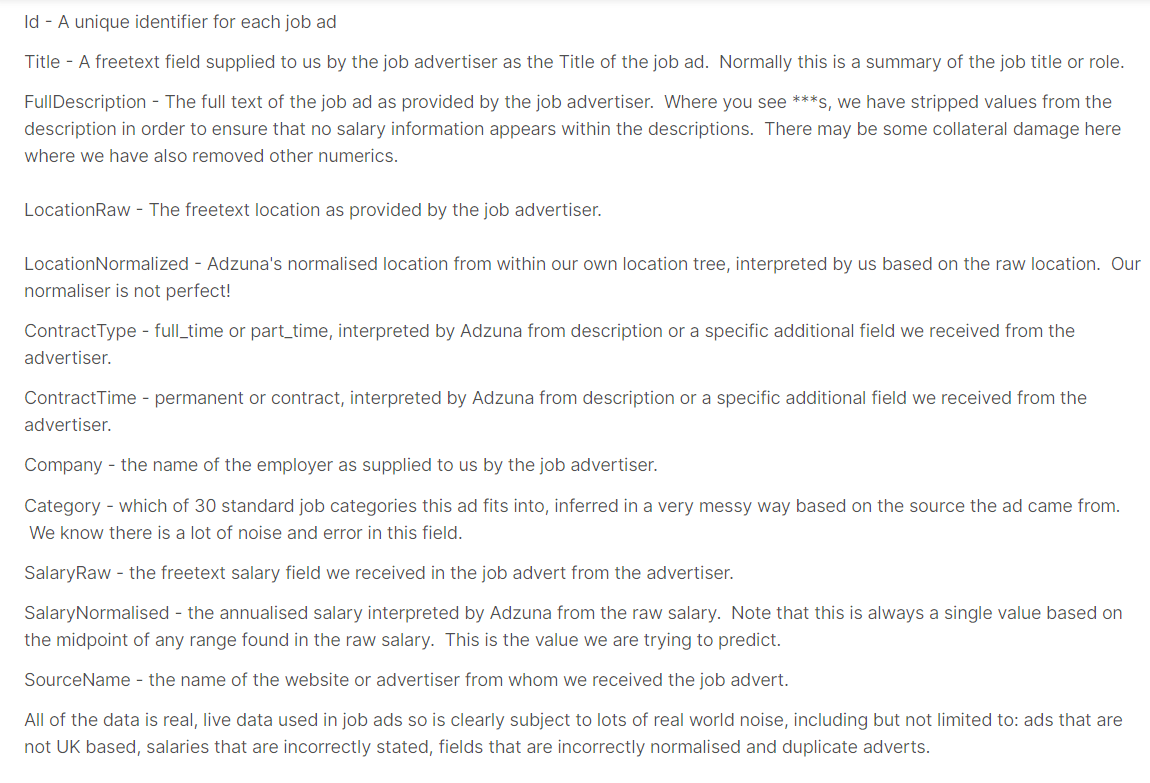

In [3]:
data = data.drop(['SalaryRaw', 'LocationRaw'], 1)

In [4]:
data['FullDescription'].values[2]

'Mathematical Modeller / Simulation Analyst / Operational Analyst Basingstoke, Hampshire Up to ****K AAE pension contribution, private medical and dental The opportunity Our client is an independent consultancy firm which has an opportunity for a Data Analyst with 35 years experience. The role will require the successful candidate to demonstrate their ability to analyse a problem and arrive at a solution, with varying levels of data being available. Essential skills Thorough knowledge of Excel and proven ability to utilise this to create powerful decision support models Experience in Modelling and Simulation Techniques, Experience of techniques such as Discrete Event Simulation and/or SD modelling Mathematical/scientific background  minimum degree qualified Proven analytical and problem solving skills Self Starter Ability to develop solid working relationships In addition to formal qualifications and experience, the successful candidate will require excellent written and verbal communi

One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

_You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description)._

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

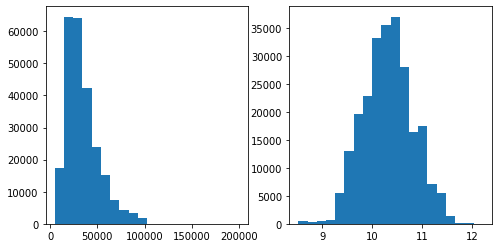

In [7]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"
data[text_columns] = data[text_columns].fillna('NaN')

data.sample(3)

,Title,FullDescription,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName,Log1pSalary
Id,,,,,,,,,,
69932150,HGV **** Tipper driver,Axiom Personnel are recuiting for experienced ...,Brentwood,NaN,contract,Axiom Personnel Ltd,Logistics & Warehouse Jobs,18240,cv-library.co.uk,9.811427
70141392,SAP Senior Security & Authorisations Consultant,SAP Security and Authorisations Consultant req...,Lincoln,NaN,permanent,NaN,IT Jobs,40000,technojobs.co.uk,10.596660
69549054,Sliding Head CNC Machine Operator,Sliding Head CNC Machine Operator Area: Sheffi...,Sheffield,full_time,NaN,Travail Employment Group,Manufacturing Jobs,16320,Jobcentre Plus,9.700208


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

__Your task__ is to lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

It's okay to use nltk tokenizers. Assertions were designed for WordPunctTokenizer, slight deviations are okay.

In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
Id
12612844    Mathematical Modeller / Simulation Analyst / O...
69538547    A successful and high achieving specialist sch...
71852369    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [22]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz

In [6]:
import en_core_web_sm

nlp = en_core_web_sm.load(disable=['tok2vec'])

C:\Users\Tania\Anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.3). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
# import nltk
# #TODO YOUR CODE HERE

# tokenizer = nltk.tokenize.WordPunctTokenizer()
# # YOUR CODE HERE

# data[text_columns] = data[text_columns].applymap(lambda x: " ".join(tokenizer.tokenize(x.lower())))

In [7]:
nlp.pipe_names

['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']

In [7]:
import string

In [8]:
punc = ''.join([sim for sim in string.punctuation if sim not in "/"])
p = '[!@#$;:%-&?<>*)(=_+}{|.,]'
# [x for x in p if x not in punc]
# set(p).issubset(punc)
p

'[!@#$;:%-&?<>*)(=_+}{|.,]'

In [9]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [10]:
import spacy
import re
nlp = spacy.load('en_core_web_sm')        
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
# spacy_stopwords

In [11]:
def tokenizer(Series):
    all_tokens = Series.apply(lambda x: re.sub(p,'',x)).str.lower(
    ).map(lambda x: ' '.join([str(i) for i in x.split(' ') if i not in spacy_stopwords]))
#     all_tokens = Series.str.lower()\
#             .map(lambda x: ' '.join([str(i) for i in x.split(' ') if i not in punc and i not in spacy_stopwords]))
#     all_tokens = Series.str.lower().map(lambda x: ' '.join([str(i) for i in x.split(' ') if i not in spacy_stopwords]))
    return pd.Series(all_tokens)

In [11]:
%%time
# print(data["FullDescription"].iloc[2][:54])
data[['FullDescription']].head(10).apply(tokenizer)

Wall time: 52.9 ms


,FullDescription
Id,
12612628,engineering systems analyst dorking surrey sal...
12612830,stress engineer glasgow salary currently loo...
12612844,mathematical modeller / simulation analyst / o...
12613049,engineering systems analyst / mathematical mod...
12613647,pioneer miser engineering systems analyst dor...
13179816,engineering systems analyst water industry loc...
14131336,globally renowned engineering training company...
14663196,live vacancy generic advertisement want earn ...
14663197,exceptional opportunity join construction / te...


In [12]:
%%time
data[text_columns] = data[text_columns].apply(tokenizer)

Wall time: 22.6 s


Now we can assume that our text is a space-separated list of tokens:

In [13]:
data["FullDescription"].iloc[2][:54]

'mathematical modeller / simulation analyst / operation'

In [14]:
data["Title"].iloc[54321]

'international digital account manager german'

In [15]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"].iloc[2][:54] == 'mathematical modeller / simulation analyst / operation'
assert data["Title"].iloc[54321] == 'international digital account manager german'

Tokenized:
Id
12612844    mathematical modeller / simulation analyst / o...
69538547    successful high achieving specialist school lo...
71852369    web designer  html css javascript photoshop il...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [13]:
from collections import Counter
token_counts = Counter()

In [14]:
%%time

# Count how many times does each token occur in both "Title" and "FullDescription" in total

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

Wall time: 9.96 s


In [15]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=7))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-7:])))

Total unique tokens : 308114
('', 1517443)
('experience', 422171)
('role', 290737)
('work', 278391)
('business', 271915)
('team', 268736)
('skills', 230290)
...
('ruabon', 1)
('andylowehayscom', 1)
('enthusiasmif', 1)
('temporary/supply/permanent', 1)
('studies/law', 1)
('gcse/ks', 1)
('teacher/nqt', 1)


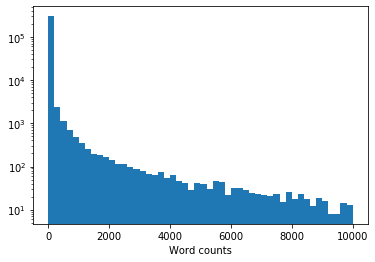

In [20]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
#TODO <YOUR CODE>
tokens = [t for t, c in token_counts.items() if c >= min_count and not (t  in ' /' or '/' in t
                                                                       or any(map(str.isdigit, t)))]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [22]:
tokens[-50:]
# tokens[:50]

['schemededicated',
 'zak',
 'marklew',
 'differentbarchester',
 'barchestera',
 'engingeer',
 'elastopolymers',
 'polymere',
 'styrenic',
 'galmorgan',
 'rhonda',
 'keyring',
 'rostrvm',
 'ofx',
 'yaf',
 '\uf06c',
 'iguanas',
 '\uf0be',
 'spba',
 'atf',
 '“support',
 'pud',
 'smax',
 "'asbestos",
 '„h',
 'tothem',
 '\uf06e',
 'porthouse',
 'mpo',
 'motivationhrcom',
 'havex',
 'personnelx',
 'fromx',
 'xfa',
 'wwwmotivationhrcom',
 'onbsp',
 'backgroundx',
 'sixteenyearolds',
 'ƒx',
 'dixonscouk',
 'jobsnbsp',
 'serc',
 'urm',
 '„�',
 'aaronsmithhclpermanentcom',
 'janavojtekovahclpermanentcom',
 'qaranc',
 'xffc',
 'raquo',
 'claas']

In [14]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
#assert len(tokens) in range(32000, 35000)
# assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34207
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [16]:
# TODO <YOUR CODE>
token_to_id = {t: i for i, t in enumerate(tokens)}

In [17]:
token_to_id

{'UNK': 0,
 'PAD': 1,
 'engineering': 2,
 'systems': 3,
 'analyst': 4,
 'stress': 5,
 'engineer': 6,
 'glasgow': 7,
 'modelling': 8,
 'simulation': 9,
 'mathematical': 10,
 'modeller': 11,
 'pioneer': 12,
 'water': 13,
 'industry': 14,
 'senior': 15,
 'subsea': 16,
 'pipeline': 17,
 'integrity': 18,
 'recruitment': 19,
 'consultant': 20,
 'industrial': 21,
 'commercial': 22,
 'construction': 23,
 'technical': 24,
 'trades': 25,
 'labour': 26,
 'cables': 27,
 'trainee': 28,
 'mortgage': 29,
 'advisor': 30,
 'east': 31,
 'midlands': 32,
 'project': 33,
 'pharmaceutical': 34,
 'principal': 35,
 'composite': 36,
 'fatigue': 37,
 'damage': 38,
 'tolerance': 39,
 'chef': 40,
 'de': 41,
 'partie': 42,
 'award': 43,
 'winning': 44,
 'restaurant': 45,
 'excellent': 46,
 'tips': 47,
 'quality': 48,
 'controls': 49,
 'dining': 50,
 'live': 51,
 'share': 52,
 'c': 53,
 'design': 54,
 'lead': 55,
 'engineers': 56,
 'relief': 57,
 'croydon': 58,
 'surrey': 59,
 'control': 60,
 'instrumentation': 61,

In [22]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [18]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [20]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000].values))

Lines:
engineering systems analyst
hr assistant
senior eci engineer

Matrix:
[[   2    3    4]
 [ 926  151    1]
 [  15 8232    6]]


In [29]:
print("Lines:")
print('\n'.join(data["FullDescription"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["FullDescription"][::100000].values))

Lines:
engineering systems analyst dorking surrey salary k client located dorking surrey looking engineering systems analyst client provides specialist software development keywords mathematical modelling risk analysis system modelling optimisation miser pioneeer engineering systems analyst dorking surrey salary k
looking hr advisor join team maternity cover role time monday friday successful candidate proven track record working hr preferably education sector responsible keeping college employee database date providing general hr support members hr team arranging meetings preparing paperwork etc candidates excellent communication skills written oral excellent oraganisational skills ability deal sensitively tactful manner staff external applicants cipd qualification knowledge recruitment staff development administration highly desirable role
client leading power generation business based scotland seeking lead ec engineer join success growing business main duties role include  lead deve

Now let's  encode the categorical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [117]:
data.nunique()

Title                 131024
FullDescription       240941
LocationRaw            20986
LocationNormalized      2732
ContractType               3
ContractTime               3
Company                20813
Category                  29
SalaryRaw              97286
SalaryNormalized        8454
SourceName               167
Log1pSalary             8454
dtype: int64

In [118]:
data['ContractTime'].value_counts()

permanent    151521
NaN           63905
contract      29342
Name: ContractTime, dtype: int64

In [19]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")


top_locations, top_counts = zip(*Counter(data['LocationNormalized']).most_common(100))
recognized_locations = set(top_locations)
data["LocationNormalized"] = data["LocationNormalized"].apply(lambda loc: loc if loc in recognized_locations else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [22]:
data[categorical_columns].head()

,Category,Company,LocationNormalized,ContractType,ContractTime
Id,,,,,
12612628,Engineering Jobs,Gregory Martin International,Other,NaN,permanent
12612830,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
12612844,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
12613049,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
12613647,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent


In [23]:
categorical_vectorizer.transform(data[categorical_columns].head(5).apply(dict, axis=1))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
categorical_vectorizer.get_feature_names()[:100 :10]

['Category=Accounting & Finance Jobs',
 'Category=HR & Recruitment Jobs',
 'Category=Part time Jobs',
 'Company=1st Place',
 'Company=ACADEMICS LTD',
 'Company=ARM',
 'Company=Aaron Wallis Sales Recruitment',
 'Company=Additional Resources',
 'Company=Advantage Technical Resourcing',
 'Company=Ambis resourcing Partnership']

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=77)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [21]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

#TODO: Look at it
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [32]:
make_batch(data_train[:5], max_len=10)

{'Title': tensor([[  15,   81,   30,    0,  922, 1072],
         [1621,  206, 1601,  151,    1,    1],
         [  87,   88,   75,    1,    1,    1],
         [  24,   20,    1,    1,    1,    1],
         [1575,    0,  443,    1,    1,    1]]),
 'FullDescription': tensor([[ 5408,   398,  1468,   922,   472, 29872,   261,    46,  1495,   922],
         [  206,     0,  1621,   651,  2883,   198,  3645,  8016,  8326,  2520],
         [14448, 12198,  1048,  1511,   906, 14704,    87,  4515,   187,  1118],
         [   24,    20,   329,  4906,  4906,   856,  2211,  5873,  1858,  5547],
         [ 1224,  2963,  1575,  4476,  3441,    22,   624,  3195, 12819,  2162]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([10.5967,  9.5325, 10.4631, 10.1659,  9.7982])}

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [22]:
import torch
import torch.nn as nn
import torch.functional as F

In [22]:
len(tokens)

34207

In [36]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
#         print(description_features.shape)
        
        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [37]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(np.unique(dummy_pred.detach().numpy())) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data. 

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [23]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [24]:
import tqdm

BATCH_SIZE = 128
EPOCHS = 1
DEVICE = torch.device('cpu')#cuda - 

In [25]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [26]:
def train(model, criterion, optimizer):
    mse_l = []
    mae_l = []
    tr_loss = []
    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                    total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            if i % 80 == 79:
                l_i = loss.item()
                print('train_loss', l_i)
                mse, mae = print_metrics(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
                mse_l.append(mse)
                mae_l.append(mae)
                tr_loss.append(l_i)
    return mse_l, mae_l, tr_loss

In [27]:
def plot_learning(mse_l, mae_l, tr_loss):

    plt.figure(figsize=(5, 5))
    plt.plot(list(range(len(mse_l))), mse_l, 'r', label='MSE')
    plt.plot(list(range(len(mae_l))), mae_l, 'b', label='MAE')
    plt.plot(list(range(len(tr_loss))), tr_loss, 'g', label='Train loss')
    plt.title('Loss and error metrics')
    plt.xlabel('Every fiftieth')
    plt.ylabel('Metrics  value')
    plt.legend()

    plt.show()

In [80]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 47.04088592529297
val results:
Mean square error: 13.69581
Mean absolute error: 1.84583
train_loss 0.7017671465873718
val results:
Mean square error: 0.71363
Mean absolute error: 0.38736
train_loss 0.598950207233429
val results:
Mean square error: 0.76394
Mean absolute error: 0.40699
train_loss 0.49481678009033203
val results:
Mean square error: 0.75806
Mean absolute error: 0.40840
train_loss 0.5294305682182312
val results:
Mean square error: 0.70690
Mean absolute error: 0.39511
train_loss 0.41052210330963135
val results:
Mean square error: 0.68915
Mean absolute error: 0.39150
train_loss 0.35014471411705017
val results:
Mean square error: 0.64635
Mean absolute error: 0.37942
train_loss 0.3118925988674164
val results:
Mean square error: 0.62622
Mean absolute error: 0.37421
train_loss 0.34160318970680237
val results:
Mean square error: 0.61580
Mean absolute error: 0.37199
train_loss 0.3743414282798767
val results:
Mean square error: 0.62461
Mean absolute error: 0.37603
train_l

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.14954036474227905
val results:
Mean square error: 0.37521
Mean absolute error: 0.28944
train_loss 0.14746178686618805
val results:
Mean square error: 0.36764
Mean absolute error: 0.28657
train_loss 0.17568062245845795
val results:
Mean square error: 0.36620
Mean absolute error: 0.28623
train_loss 0.24592842161655426
val results:
Mean square error: 0.33383
Mean absolute error: 0.27209
train_loss 0.17850232124328613
val results:
Mean square error: 0.33450
Mean absolute error: 0.27277
train_loss 0.17402048408985138
val results:
Mean square error: 0.33341
Mean absolute error: 0.27245
train_loss 0.1349119246006012
val results:
Mean square error: 0.30527
Mean absolute error: 0.25950
train_loss 0.20151546597480774
val results:
Mean square error: 0.31974
Mean absolute error: 0.26668
train_loss 0.142055481672287
val results:
Mean square error: 0.28217
Mean absolute error: 0.24892
train_loss 0.17497627437114716
val results:
Mean square error: 0.27416
Mean absolute error: 0.24513
tra

Best metrics values
min mse 0.18827434380849203, idx in list 41
min mae 0.19919860363006592, idx in list 41


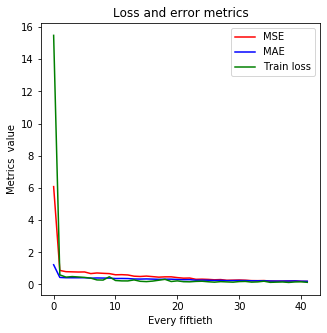

In [43]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

In [42]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

Результаты на тестовой выборке
 results:
Mean square error: 0.15349
Mean absolute error: 0.17673


## Выполнение заданий ЛР

### 1. Развитие СNN архитектуры

In [150]:
class SalaryPredictor_1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.BatchNorm1d(hid_size),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.Conv1d(hid_size, hid_size, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [145]:
model = SalaryPredictor_1().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 4.672912120819092
val results:
Mean square error: 3.48256
Mean absolute error: 0.91062
train_loss 1.0592565536499023
val results:
Mean square error: 1.02425
Mean absolute error: 0.46494
train_loss 1.3324483633041382
val results:
Mean square error: 0.71848
Mean absolute error: 0.38481
train_loss 1.1849149465560913
val results:
Mean square error: 0.84666
Mean absolute error: 0.43118
train_loss 0.593030571937561
val results:
Mean square error: 0.68036
Mean absolute error: 0.38550
train_loss 0.4638247489929199
val results:
Mean square error: 0.55314
Mean absolute error: 0.34539
train_loss 0.5561172962188721
val results:
Mean square error: 0.53931
Mean absolute error: 0.34348
train_loss 0.34703877568244934
val results:
Mean square error: 0.43238
Mean absolute error: 0.30495
train_loss 0.3814627230167389
val results:
Mean square error: 0.41621
Mean absolute error: 0.30053
train_loss 0.29423826932907104
val results:
Mean square error: 0.40227
Mean absolute error: 0.29625
train_loss

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 1.1700465679168701
val results:
Mean square error: 0.19973
Mean absolute error: 0.20299
train_loss 0.17744316160678864
val results:
Mean square error: 0.18828
Mean absolute error: 0.19653
train_loss 0.19276072084903717
val results:
Mean square error: 0.16452
Mean absolute error: 0.18170
train_loss 0.17098984122276306
val results:
Mean square error: 0.20951
Mean absolute error: 0.20993
train_loss 0.15005485713481903
val results:
Mean square error: 0.15990
Mean absolute error: 0.17930
train_loss 0.16587325930595398
val results:
Mean square error: 0.15896
Mean absolute error: 0.17891
train_loss 0.17143559455871582
val results:
Mean square error: 0.17422
Mean absolute error: 0.18915
train_loss 0.5708870887756348
val results:
Mean square error: 0.12607
Mean absolute error: 0.15590
train_loss 0.19824448227882385
val results:
Mean square error: 0.12626
Mean absolute error: 0.15619
train_loss 0.15490780770778656
val results:
Mean square error: 0.11371
Mean absolute error: 0.14653
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.17871038615703583
val results:
Mean square error: 0.07662
Mean absolute error: 0.11566
train_loss 0.13073444366455078
val results:
Mean square error: 0.06507
Mean absolute error: 0.10456
train_loss 0.11918623745441437
val results:
Mean square error: 0.08278
Mean absolute error: 0.12151
train_loss 0.22324232757091522
val results:
Mean square error: 0.06311
Mean absolute error: 0.10295
train_loss 0.17414234578609467
val results:
Mean square error: 0.05891
Mean absolute error: 0.09861
train_loss 0.1517324149608612
val results:
Mean square error: 0.06712
Mean absolute error: 0.10697
train_loss 0.1024019718170166
val results:
Mean square error: 0.08314
Mean absolute error: 0.12233
train_loss 0.16740666329860687
val results:
Mean square error: 0.05707
Mean absolute error: 0.09694
train_loss 0.11809185147285461
val results:
Mean square error: 0.06072
Mean absolute error: 0.10090
train_loss 0.12863099575042725
val results:
Mean square error: 0.05829
Mean absolute error: 0.09835
tr

In [ ]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

### SalaryPredictor_2
* ***В исходную модель добавлены: Batch Norm (nn.BatchNorm), параллельные сверточные слои для текстовых полей и добавлен ещё один слой в final_predictor***

In [35]:
# !pip install pytorchtools

In [66]:
# from pytorchtools import EarlyStopping
# from torchsample.callbacks import EarlyStopping

In [67]:
class SalaryPredictor_2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder_1 = nn.Sequential(
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.title_encoder_2 = nn.Sequential(
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_1 = nn.Sequential(
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder_2 = nn.Sequential(
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.BatchNorm1d(n_cat_features),
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size * 2),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.BatchNorm1d(hid_size * 6),
            nn.Linear(hid_size * 6, hid_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size * 2),
            nn.Linear(hid_size * 2, hid_size),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features_1 = self.title_encoder_1(title_embeddings)
        title_features_2 = self.title_encoder_2(title_embeddings)
        title_features = torch.cat([title_features_1, title_features_2], dim=1).squeeze()
        

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features_1 = self.description_encoder_1(description_embeddings)
        description_features_2 = self.description_encoder_2(description_embeddings)
        description_features = torch.cat([description_features_1, description_features_2], dim=1).squeeze()

        categorical_features = self.categorical_encoder(batch['Categorical'])

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
#         early_stopping(valid_loss, model)
        
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break

        
        return self.final_predictor(features).squeeze()

In [75]:
model = SalaryPredictor_2().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 105.50826263427734
val results:
Mean square error: 25.94155
Mean absolute error: 2.54314
train_loss 94.57686614990234
val results:
Mean square error: 23.14727
Mean absolute error: 2.39137
train_loss 80.54220581054688
val results:
Mean square error: 20.30803
Mean absolute error: 2.24359
train_loss 66.31034851074219
val results:
Mean square error: 15.96721
Mean absolute error: 1.98248
train_loss 49.76600646972656
val results:
Mean square error: 11.99013
Mean absolute error: 1.71191
train_loss 34.37070083618164
val results:
Mean square error: 8.16801
Mean absolute error: 1.40767
train_loss 21.505844116210938
val results:
Mean square error: 5.30721
Mean absolute error: 1.13667
train_loss 12.980210304260254
val results:
Mean square error: 3.08506
Mean absolute error: 0.85165
train_loss 6.441723346710205
val results:
Mean square error: 1.70342
Mean absolute error: 0.62484
train_loss 3.077230453491211
val results:
Mean square error: 1.00513
Mean absolute error: 0.43921
train_loss 1

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.11953689157962799
val results:
Mean square error: 0.68406
Mean absolute error: 0.15896
train_loss 0.10310657322406769
val results:
Mean square error: 0.48138
Mean absolute error: 0.13650
train_loss 0.10780567675828934
val results:
Mean square error: 0.33408
Mean absolute error: 0.12912
train_loss 0.11474774032831192
val results:
Mean square error: 0.39048
Mean absolute error: 0.13847
train_loss 0.10702946782112122
val results:
Mean square error: 0.28787
Mean absolute error: 0.12301
train_loss 0.1224045529961586
val results:
Mean square error: 0.31832
Mean absolute error: 0.12715
train_loss 0.10256949067115784
val results:
Mean square error: 0.30528
Mean absolute error: 0.12142
train_loss 0.11719207465648651
val results:
Mean square error: 0.39464
Mean absolute error: 0.12953
train_loss 0.09810160845518112
val results:
Mean square error: 0.28434
Mean absolute error: 0.12225
train_loss 0.12908653914928436
val results:
Mean square error: 0.38654
Mean absolute error: 0.13670
t

Best metrics values
min mse 0.2843441168467204, idx in list 29
min mae 0.11461298664410909, idx in list 29


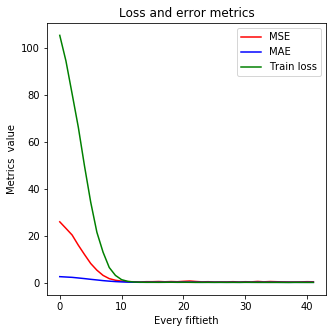

In [79]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

In [ ]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

Очевидно, при увеличении количества слоёв в модели, скорость обучения сильно снижается, но при этом сразу видно низкие потери на обучающей выборке

### 2. Стандартные рooling слои

* Pooling слой понижает размерность карты признаков: из группы элементов слоя к дальнейшим преобразованиям переходит только имеющий макимальное значение
* В NLP каждая строка матрицы соотносится с набором токенов, поэтому сверточные слои применяются к строкам целиком (имеют те же размеры); наибольшее число из каждой карты признаков, образованной сверточным слоем;
* Если свёрточным слоем была найдена информация о наличии какого-либо признака (словосочетания) в предложении, Pooling слой отбрасывает информацию, в каком именно месте предложения признак встретился, оставляя в качестве информации только факт его появления

* [ref] http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

In [130]:
class SalaryPredictor_pool_avg(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.title_encoder = nn.Sequential(
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1)
#             nn.AvgPool1d(kernel_size=hid_size, count_include_pad=False)
        )
        
        self.description_encoder = nn.Sequential(
            nn.BatchNorm1d(hid_size),
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1)
#             nn.AvgPool2d(kernel_size=hid_size*32, count_include_pad=False)
        )

        self.categorical_encoder = nn.Sequential(
            nn.BatchNorm1d(n_cat_features),
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size * 2),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.BatchNorm1d(hid_size * 4),
            nn.Linear(hid_size * 4, hid_size * 2),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size * 2),
            nn.Linear(hid_size * 2, hid_size),
            nn.ReLU(),
            nn.BatchNorm1d(hid_size),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
#         print(title_embeddings.shape)
        title_features = self.title_encoder(title_embeddings).squeeze()
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
#         print(description_embeddings.shape)
        description_features = self.description_encoder(description_embeddings).squeeze()
#         print(description_features.shape)

        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
#         early_stopping(valid_loss, model)
        
#         if early_stopping.early_stop:
#             print("Early stopping")
#             break

        
        return self.final_predictor(features).squeeze()

In [131]:
model = SalaryPredictor_pool_avg().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 95.6103744506836
val results:
Mean square error: 24.32463
Mean absolute error: 2.46136
train_loss 88.93708038330078
val results:
Mean square error: 22.96778
Mean absolute error: 2.37550
train_loss 75.02558898925781
val results:
Mean square error: 19.67413
Mean absolute error: 2.20057
train_loss 61.57421875
val results:
Mean square error: 15.59475
Mean absolute error: 1.95382
train_loss 44.61495590209961
val results:
Mean square error: 11.61383
Mean absolute error: 1.68444
train_loss 31.167226791381836
val results:
Mean square error: 7.74964
Mean absolute error: 1.37709
train_loss 19.162080764770508
val results:
Mean square error: 4.91676
Mean absolute error: 1.08767
train_loss 10.725753784179688
val results:
Mean square error: 2.71998
Mean absolute error: 0.80273
train_loss 5.138499736785889
val results:
Mean square error: 1.45913
Mean absolute error: 0.57840
train_loss 2.326596260070801
val results:
Mean square error: 0.61622
Mean absolute error: 0.36222
train_loss 0.918498

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.12065598368644714
val results:
Mean square error: 1.16983
Mean absolute error: 0.15647
train_loss 0.08209091424942017
val results:
Mean square error: 1.97066
Mean absolute error: 0.19708
train_loss 0.09513585269451141
val results:
Mean square error: 0.13214
Mean absolute error: 0.09802
train_loss 0.14831985533237457
val results:
Mean square error: 0.12824
Mean absolute error: 0.09704
train_loss 0.11779406666755676
val results:
Mean square error: 0.10068
Mean absolute error: 0.09088
train_loss 0.09845906496047974
val results:
Mean square error: 0.12951
Mean absolute error: 0.09805
train_loss 0.10465186834335327
val results:
Mean square error: 0.09782
Mean absolute error: 0.08893
train_loss 0.11999824643135071
val results:
Mean square error: 0.12473
Mean absolute error: 0.09390
train_loss 0.09450045228004456
val results:
Mean square error: 0.12631
Mean absolute error: 0.09669
train_loss 0.08979228883981705
val results:
Mean square error: 0.13959
Mean absolute error: 0.09993


Best metrics values
min mse 0.09781777858734131, idx in list 27
min mae 0.08871457974116008, idx in list 27


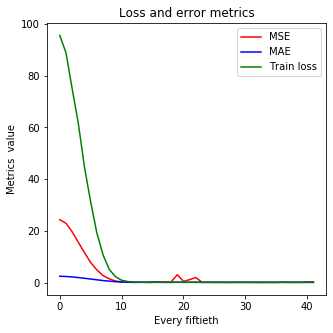

In [132]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

In [133]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

Результаты на тестовой выборке
 results:
Mean square error: 0.25860
Mean absolute error: 0.11024


### 3. Предобученные эмбеддинги

[ref] https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

[ref] https://radimrehurek.com/gensim/models/word2vec.html

* classmethod from_pretrained(embeddings, freeze=True), True - по умолчанию (необучаемые)
        freeze - параметр, идентифицирующий, будут ли веса в embedding обучаться в процессе
        
[ref] https://colab.research.google.com/github/dpressel/dlss-tutorial/blob/master/1_pretrained_vectors.ipynb#scrollTo=u_ZR8A0x6XQh

In [96]:
# conda update numpy
# import numpy
# numpy.__version__
# !pip install python-Levenshtein
# from gensim.test.utils import common_texts

In [43]:
# m = Word2Vec(sentences=common_texts, vector_size=8, window=5, min_count=1, workers=4)
# m.train([["hello", "world"]], total_examples=1, epochs=1)

In [134]:
import gensim
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors

C:\Anaconda\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


***Gensim Downloader Load 'glove-twitter-25'***

**Модель с необучаемыми (замороженными) весами  freeze=True**

In [135]:
# api.info()
glove_vectors = gensim.downloader.load('glove-twitter-25')

In [54]:
# это если все вектора загружать - лишнее
# weights = torch.FloatTensor(glove_vectors.vectors) # длина вектора - 25, надо изменить в классе нейросети hid_size=25
# weights.shape

torch.Size([1193514, 25])

In [137]:
id_to_tocken = {value:key for key, value in token_to_id.items()}

weights = torch.zeros(len(token_to_id)+1, glove_vectors.vector_size)

for i in range(len(token_to_id)+1):
    try:
        weights[i, :] = torch.from_numpy(glove_vectors.get_vector(id_to_tocken[i]))
    except:
        continue

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  import sys


In [138]:
class SalaryPredictor_pretrained_vecs(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=25):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size).from_pretrained(weights)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
#         print(description_features.shape)
        
        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [139]:
model = SalaryPredictor_pretrained_vecs().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.8799697160720825
val results:
Mean square error: 1.41329
Mean absolute error: 0.57054
train_loss 0.5823937058448792
val results:
Mean square error: 0.86770
Mean absolute error: 0.44160
train_loss 0.38219955563545227
val results:
Mean square error: 0.82784
Mean absolute error: 0.43565
train_loss 0.36006659269332886
val results:
Mean square error: 0.76750
Mean absolute error: 0.42108
train_loss 0.255688339471817
val results:
Mean square error: 0.68115
Mean absolute error: 0.39651
train_loss 0.20450495183467865
val results:
Mean square error: 0.68110
Mean absolute error: 0.39787
train_loss 0.23901495337486267
val results:
Mean square error: 0.63538
Mean absolute error: 0.38394
train_loss 0.22963464260101318
val results:
Mean square error: 0.62795
Mean absolute error: 0.38229
train_loss 0.1511235237121582
val results:
Mean square error: 0.59918
Mean absolute error: 0.37326
train_loss 0.1598302572965622
val results:
Mean square error: 0.57277
Mean absolute error: 0.36472
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1628635972738266
val results:
Mean square error: 0.38380
Mean absolute error: 0.29597
train_loss 0.144778773188591
val results:
Mean square error: 0.40911
Mean absolute error: 0.30669
train_loss 0.11484824866056442
val results:
Mean square error: 0.40848
Mean absolute error: 0.30646
train_loss 0.19192537665367126
val results:
Mean square error: 0.39701
Mean absolute error: 0.30190
train_loss 0.13114726543426514
val results:
Mean square error: 0.39669
Mean absolute error: 0.30195
train_loss 0.15284767746925354
val results:
Mean square error: 0.38900
Mean absolute error: 0.29882
train_loss 0.1510242521762848
val results:
Mean square error: 0.35498
Mean absolute error: 0.28446
train_loss 0.2179630547761917
val results:
Mean square error: 0.34108
Mean absolute error: 0.27834
train_loss 0.17483305931091309
val results:
Mean square error: 0.36195
Mean absolute error: 0.28758
train_loss 0.12959612905979156
val results:
Mean square error: 0.35440
Mean absolute error: 0.28432
train

Best metrics values
min mse 0.24684385458628336, idx in list 38
min mae 0.23410656054814658, idx in list 38


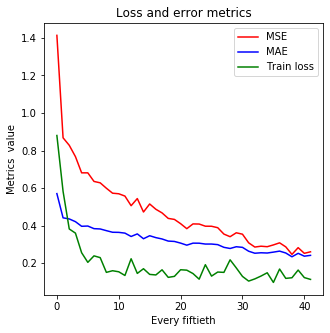

In [140]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

In [141]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

Результаты на тестовой выборке
 results:
Mean square error: 0.40826
Mean absolute error: 0.30825


* ***со всеми загруженными векторами из glove***

In [120]:
model = SalaryPredictor_pretrained_vecs().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

C:\Anaconda\lib\site-packages\torch\autograd\__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


train_loss 0.6567522287368774
val results:
Mean square error: 1.63472
Mean absolute error: 0.62359
train_loss 0.33479177951812744
val results:
Mean square error: 1.21896
Mean absolute error: 0.53644
train_loss 0.36017754673957825
val results:
Mean square error: 1.23677
Mean absolute error: 0.54284
train_loss 0.31368085741996765
val results:
Mean square error: 1.15765
Mean absolute error: 0.52572
train_loss 0.22106435894966125
val results:
Mean square error: 1.16724
Mean absolute error: 0.52891
train_loss 0.15722021460533142
val results:
Mean square error: 1.13739
Mean absolute error: 0.52243
train_loss 0.27861788868904114
val results:
Mean square error: 1.16803
Mean absolute error: 0.53020
train_loss 0.17112141847610474
val results:
Mean square error: 1.10314
Mean absolute error: 0.51507
train_loss 0.2578660547733307
val results:
Mean square error: 1.16573
Mean absolute error: 0.53034
train_loss 0.20264430344104767
val results:
Mean square error: 1.11351
Mean absolute error: 0.51813
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10738411545753479
val results:
Mean square error: 1.03621
Mean absolute error: 0.50096
train_loss 0.11549309641122818
val results:
Mean square error: 1.03666
Mean absolute error: 0.50112
train_loss 0.1363697648048401
val results:
Mean square error: 1.05648
Mean absolute error: 0.50617
train_loss 0.1534334272146225
val results:
Mean square error: 0.96890
Mean absolute error: 0.48410
train_loss 0.1252449005842209
val results:
Mean square error: 0.98621
Mean absolute error: 0.48862
train_loss 0.12381668388843536
val results:
Mean square error: 1.01242
Mean absolute error: 0.49528
train_loss 0.13789017498493195
val results:
Mean square error: 1.01910
Mean absolute error: 0.49707
train_loss 0.14095261693000793
val results:
Mean square error: 1.00514
Mean absolute error: 0.49359
train_loss 0.1052226647734642
val results:
Mean square error: 0.98462
Mean absolute error: 0.48846
train_loss 0.1283365935087204
val results:
Mean square error: 1.05611
Mean absolute error: 0.50644
train

Best metrics values
min mse 0.9683196544647217, idx in list 37
min mae 0.4840981165568034, idx in list 37


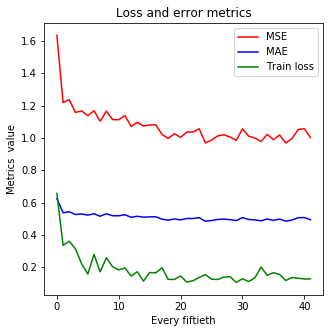

In [121]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

In [122]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

Результаты на тестовой выборке
 results:
Mean square error: 0.85582
Mean absolute error: 0.45481


**Модель с обучаемыми весами  freeze=False и другой моделью gensim - word2vec-google-news-300**

In [49]:
# word_vectors =api.load('word2vec-google-news-300') # недостаточно памяти - невозможно работать с такой размерностью векторов
# weights = torch.FloatTensor(word_vectors.vectors)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [142]:
class SalaryPredictor_pretrained_ft(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=25):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size).from_pretrained(weights, freeze=False)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)
        title_features = self.title_encoder(title_embeddings).squeeze()
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
#         print(description_features.shape)
        
        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [143]:
model = SalaryPredictor_pretrained_ft().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.9921307563781738
val results:
Mean square error: 1.24798
Mean absolute error: 0.52945
train_loss 0.7329913377761841
val results:
Mean square error: 0.90128
Mean absolute error: 0.44967
train_loss 0.49062463641166687
val results:
Mean square error: 0.82647
Mean absolute error: 0.43463
train_loss 0.2793479561805725
val results:
Mean square error: 0.77111
Mean absolute error: 0.42209
train_loss 0.28608816862106323
val results:
Mean square error: 0.75218
Mean absolute error: 0.41871
train_loss 0.2881559729576111
val results:
Mean square error: 0.70939
Mean absolute error: 0.40743
train_loss 0.2494046539068222
val results:
Mean square error: 0.69633
Mean absolute error: 0.40459
train_loss 0.1689712554216385
val results:
Mean square error: 0.67845
Mean absolute error: 0.39976
train_loss 0.18317237496376038
val results:
Mean square error: 0.64511
Mean absolute error: 0.38983
train_loss 0.20590165257453918
val results:
Mean square error: 0.63120
Mean absolute error: 0.38601
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.07829739153385162
val results:
Mean square error: 0.46950
Mean absolute error: 0.33285
train_loss 0.09728322923183441
val results:
Mean square error: 0.56364
Mean absolute error: 0.36653
train_loss 0.1375056505203247
val results:
Mean square error: 0.50513
Mean absolute error: 0.34621
train_loss 0.11926211416721344
val results:
Mean square error: 0.51905
Mean absolute error: 0.35113
train_loss 0.0964614599943161
val results:
Mean square error: 0.51288
Mean absolute error: 0.34920
train_loss 0.0996670052409172
val results:
Mean square error: 0.49992
Mean absolute error: 0.34458
train_loss 0.11372106522321701
val results:
Mean square error: 0.51871
Mean absolute error: 0.35140
train_loss 0.10094043612480164
val results:
Mean square error: 0.55568
Mean absolute error: 0.36440
train_loss 0.0778433233499527
val results:
Mean square error: 0.52717
Mean absolute error: 0.35452
train_loss 0.07405208051204681
val results:
Mean square error: 0.53186
Mean absolute error: 0.35630
trai

Best metrics values
min mse 0.4694970448811849, idx in list 21
min mae 0.33284588654836017, idx in list 21


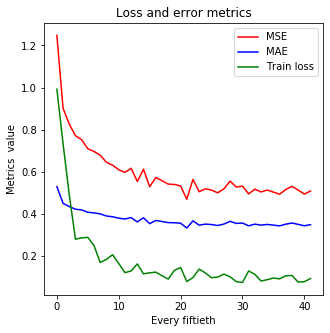

In [144]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

In [145]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

Результаты на тестовой выборке
 results:
Mean square error: 0.45461
Mean absolute error: 0.32872


* ***со всеми загруженными векторами из glove***

In [56]:
model = SalaryPredictor_pretrained_ft().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.4614516496658325
val results:
Mean square error: 1.20714
Mean absolute error: 0.53046
train_loss 0.29187119007110596
val results:
Mean square error: 1.18609
Mean absolute error: 0.52878
train_loss 0.2855818569660187
val results:
Mean square error: 1.13192
Mean absolute error: 0.51848
train_loss 0.23786310851573944
val results:
Mean square error: 1.09264
Mean absolute error: 0.51072
train_loss 0.19473466277122498
val results:
Mean square error: 1.12419
Mean absolute error: 0.51947
train_loss 0.16382618248462677
val results:
Mean square error: 1.14135
Mean absolute error: 0.52433
train_loss 0.19951792061328888
val results:
Mean square error: 1.07001
Mean absolute error: 0.50766
train_loss 0.17806072533130646
val results:
Mean square error: 1.07820
Mean absolute error: 0.51009
train_loss 0.1528538018465042
val results:
Mean square error: 1.13551
Mean absolute error: 0.52426
train_loss 0.13439184427261353
val results:
Mean square error: 1.10572
Mean absolute error: 0.51734
tra

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.0898490622639656
val results:
Mean square error: 1.06281
Mean absolute error: 0.50880
train_loss 0.08896838873624802
val results:
Mean square error: 1.02205
Mean absolute error: 0.49881
train_loss 0.14861729741096497
val results:
Mean square error: 1.03231
Mean absolute error: 0.50153
train_loss 0.10540711879730225
val results:
Mean square error: 1.03319
Mean absolute error: 0.50181
train_loss 0.08063102513551712
val results:
Mean square error: 1.08111
Mean absolute error: 0.51364
train_loss 0.13233673572540283
val results:
Mean square error: 1.07008
Mean absolute error: 0.51110
train_loss 0.1313650906085968
val results:
Mean square error: 0.98737
Mean absolute error: 0.49051
train_loss 0.09457176923751831
val results:
Mean square error: 1.08092
Mean absolute error: 0.51390
train_loss 0.10229436308145523
val results:
Mean square error: 1.01557
Mean absolute error: 0.49779
train_loss 0.0913301482796669
val results:
Mean square error: 1.09227
Mean absolute error: 0.51675
tra

Best metrics values
min mse 0.9873695373535156, idx in list 27
min mae 0.4905109802881877, idx in list 27


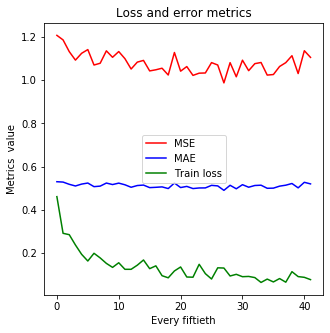

In [57]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

In [58]:
print('Результаты на тестовой выборке')
mse_test, mae_test = print_metrics(model, data_val)

Результаты на тестовой выборке
 results:
Mean square error: 0.95573
Mean absolute error: 0.48317


***Вывод: модель с предобученными векторами и обучаемыми весами достигает своего лучшего результата намного быстрее (на ~400 итераций), но значения ошибок при этом на 0.1 выше.***
* ***Относительно всех остальных моделей (с рандомными, полученными из нормального распределения, весами), можно увидеть насколько отличаются графики обучения, здесь значения ошибок постоянно колеблются (увеличиваясь и уменьшаясь), но значения ошибок изначально очень малы, когда для рандомной инициализации, независимо от других параметров и слоев нейросети, значения ошибок изначально могут быть достаточно высокими, затем очень резко падают и далее только очень незначительно уменьшаются***

### 4. Модели с рекуррентными слоями

[ref] https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

[ref] https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

### GRU - замена сверточных слоев рекуррентными

In [182]:
class SalaryPredictor_gru(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        
        self.embedder = nn.Embedding(n_tokens, hid_size)
        
        self.gru = nn.GRU(input_size=hid_size,
                            hidden_size=hid_size,
                            num_layers=1,
                            batch_first=True,
                            dropout=0.25)
        
        self.linear = nn.Linear(hid_size, hid_size)
        
       
        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title'])
#         title_features = self.title_encoder(title_embeddings).squeeze()
#         print(title_embeddings.shape)
        gru_out_t, ht_t = self.gru(title_embeddings)
#         print(ht_t[-1].shape)
        title_features = self.linear(ht_t[-1])
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription'])
#         description_features = self.description_encoder(description_embeddings).squeeze()
        gru_out_d, ht_d = self.gru(description_embeddings)
        description_features = self.linear(ht_d[-1])
#         print(description_features.shape)

        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [183]:
model = SalaryPredictor_gru().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 77.31399536132812
val results:
Mean square error: 19.04096
Mean absolute error: 2.17820
train_loss 0.39884719252586365
val results:
Mean square error: 0.10184
Mean absolute error: 0.12658
train_loss 0.33006271719932556
val results:
Mean square error: 0.07362
Mean absolute error: 0.10636
train_loss 0.19440768659114838
val results:
Mean square error: 0.05479
Mean absolute error: 0.09090
train_loss 0.21598735451698303
val results:
Mean square error: 0.04741
Mean absolute error: 0.08409
train_loss 0.21827393770217896
val results:
Mean square error: 0.04443
Mean absolute error: 0.08149
train_loss 0.20830048620700836
val results:
Mean square error: 0.04309
Mean absolute error: 0.08021
train_loss 0.16549627482891083
val results:
Mean square error: 0.04178
Mean absolute error: 0.07926
train_loss 0.18639852106571198
val results:
Mean square error: 0.04109
Mean absolute error: 0.07869
train_loss 0.15739502012729645
val results:
Mean square error: 0.04043
Mean absolute error: 0.07830
t

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.10945385694503784
val results:
Mean square error: 0.03676
Mean absolute error: 0.07448
train_loss 0.13664588332176208
val results:
Mean square error: 0.03691
Mean absolute error: 0.07469
train_loss 0.1490127295255661
val results:
Mean square error: 0.03681
Mean absolute error: 0.07456
train_loss 0.14942121505737305
val results:
Mean square error: 0.03656
Mean absolute error: 0.07421
train_loss 0.15219512581825256
val results:
Mean square error: 0.03637
Mean absolute error: 0.07400
train_loss 0.11841058731079102
val results:
Mean square error: 0.03677
Mean absolute error: 0.07460
train_loss 0.15284450352191925
val results:
Mean square error: 0.03635
Mean absolute error: 0.07400
train_loss 0.1672486513853073
val results:
Mean square error: 0.03661
Mean absolute error: 0.07388
train_loss 0.15462061762809753
val results:
Mean square error: 0.03630
Mean absolute error: 0.07375
train_loss 0.15052743256092072
val results:
Mean square error: 0.03620
Mean absolute error: 0.07360
tr

Best metrics values
min mse 0.03566203514734904, idx in list 40
min mae 0.07289805014928182, idx in list 40


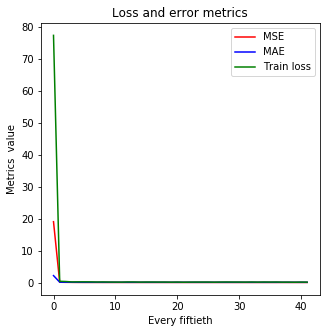

In [184]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

### Сочетание рекуррентных и сверточных слоев c LSTM
#### Сначала - сверточный слой, затем рекуррентный
**однонаправленная сеть bidirectional=False**

In [145]:
class SalaryPredictor_rec_1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.lstm = nn.LSTM(input_size=hid_size,
                            hidden_size=hid_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)
        
        self.linear = nn.Linear(hid_size, hid_size)
        
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=hid_size)
        )
 
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=hid_size)
        )

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)   
        title_features = self.title_encoder(title_embeddings).squeeze()
        lstm_out_t, (ht_t, ct_t) = self.lstm(title_features)
        title_features = self.linear(ht_t[-1])
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
        lstm_out_d, (ht_d, ct_d) = self.lstm(description_features)
        description_features = self.linear(ht_d[-1])
#         print(description_features.shape)

        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [146]:
model = SalaryPredictor_rec_1().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 68.56779479980469
val results:
Mean square error: 16.73634
Mean absolute error: 2.04183
train_loss 0.30979692935943604
val results:
Mean square error: 0.07579
Mean absolute error: 0.11075
train_loss 0.2494683414697647
val results:
Mean square error: 0.06683
Mean absolute error: 0.10311
train_loss 0.19126299023628235
val results:
Mean square error: 0.05858
Mean absolute error: 0.09614
train_loss 0.18975533545017242
val results:
Mean square error: 0.04880
Mean absolute error: 0.08682
train_loss 0.15019994974136353
val results:
Mean square error: 0.04462
Mean absolute error: 0.08230
train_loss 0.17532645165920258
val results:
Mean square error: 0.04451
Mean absolute error: 0.08201
train_loss 0.18800483644008636
val results:
Mean square error: 0.04118
Mean absolute error: 0.07884
train_loss 0.14572708308696747
val results:
Mean square error: 0.04068
Mean absolute error: 0.07821
train_loss 0.14524845778942108
val results:
Mean square error: 0.03918
Mean absolute error: 0.07697
tr

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.1326788365840912
val results:
Mean square error: 0.03593
Mean absolute error: 0.07312
train_loss 0.12037694454193115
val results:
Mean square error: 0.03441
Mean absolute error: 0.07160
train_loss 0.12934130430221558
val results:
Mean square error: 0.03416
Mean absolute error: 0.07125
train_loss 0.15667693316936493
val results:
Mean square error: 0.03573
Mean absolute error: 0.07272
train_loss 0.12701410055160522
val results:
Mean square error: 0.03534
Mean absolute error: 0.07225
train_loss 0.14414457976818085
val results:
Mean square error: 0.03419
Mean absolute error: 0.07105
train_loss 0.1299380660057068
val results:
Mean square error: 0.03432
Mean absolute error: 0.07124
train_loss 0.12265636771917343
val results:
Mean square error: 0.03344
Mean absolute error: 0.07036
train_loss 0.1709141582250595
val results:
Mean square error: 0.03251
Mean absolute error: 0.06933
train_loss 0.17222914099693298
val results:
Mean square error: 0.03422
Mean absolute error: 0.07103
tra

Best metrics values
min mse 0.029996231198310852, idx in list 40
min mae 0.06589590013027191, idx in list 40


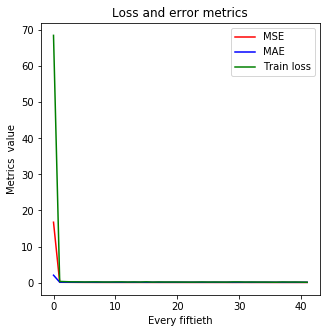

In [148]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

**двунаправленная сеть bidirectional=True**

In [27]:
class SalaryPredictor_rec_2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.lstm = nn.LSTM(input_size=hid_size,
                            hidden_size=hid_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        
        self.linear = nn.Linear(hid_size, hid_size)
        
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=hid_size)
        )

        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=hid_size)
        )

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        

        
    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)   
        title_features = self.title_encoder(title_embeddings).squeeze()
        lstm_out_t, (ht_t, ct_t) = self.lstm(title_features)
        title_features = self.linear(ht_t[-1])
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
        lstm_out_d, (ht_d, ct_d) = self.lstm(description_features)
        description_features = self.linear(ht_d[-1])
#         print(description_features.shape)

        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze()

In [150]:
model = SalaryPredictor_rec_2().to(DEVICE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

mse_l, mae_l, tr_loss = train(model, criterion, optimizer)

epoch: 0


  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 90.65847778320312
val results:
Mean square error: 22.43072
Mean absolute error: 2.36486
train_loss 0.7761229276657104
val results:
Mean square error: 0.18063
Mean absolute error: 0.17390
train_loss 0.3555082678794861
val results:
Mean square error: 0.08238
Mean absolute error: 0.11581
train_loss 0.21824166178703308
val results:
Mean square error: 0.06734
Mean absolute error: 0.10409
train_loss 0.28667664527893066
val results:
Mean square error: 0.05794
Mean absolute error: 0.09594
train_loss 0.20045994222164154
val results:
Mean square error: 0.05164
Mean absolute error: 0.09000
train_loss 0.2010931372642517
val results:
Mean square error: 0.04835
Mean absolute error: 0.08648
train_loss 0.17366750538349152
val results:
Mean square error: 0.04512
Mean absolute error: 0.08329
train_loss 0.2022511512041092
val results:
Mean square error: 0.04286
Mean absolute error: 0.08111
train_loss 0.1667047142982483
val results:
Mean square error: 0.04155
Mean absolute error: 0.07970
train_

  0%|          | 0/1721 [00:00<?, ?it/s]

train_loss 0.11005741357803345
val results:
Mean square error: 0.03797
Mean absolute error: 0.07558
train_loss 0.1925058662891388
val results:
Mean square error: 0.03777
Mean absolute error: 0.07541
train_loss 0.1308709681034088
val results:
Mean square error: 0.03771
Mean absolute error: 0.07533
train_loss 0.16275376081466675
val results:
Mean square error: 0.03760
Mean absolute error: 0.07523
train_loss 0.15917614102363586
val results:
Mean square error: 0.03734
Mean absolute error: 0.07490
train_loss 0.14847463369369507
val results:
Mean square error: 0.03733
Mean absolute error: 0.07470
train_loss 0.12929686903953552
val results:
Mean square error: 0.03710
Mean absolute error: 0.07446
train_loss 0.17199307680130005
val results:
Mean square error: 0.03637
Mean absolute error: 0.07380
train_loss 0.1770157814025879
val results:
Mean square error: 0.03586
Mean absolute error: 0.07331
train_loss 0.16188764572143555
val results:
Mean square error: 0.03504
Mean absolute error: 0.07218
tra

Best metrics values
min mse 0.029739253222942352, idx in list 39
min mae 0.06570772329966228, idx in list 39


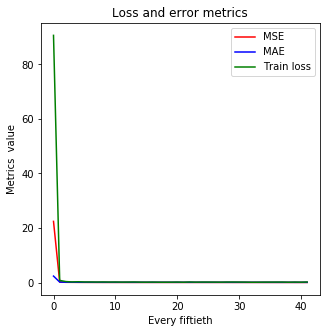

In [151]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

**Другой способ совмещения рукуррентных и сверточных слоев (сначала рекуррентный, затем сверточный)**

In [ ]:
print('Best metrics values')
print(f'min mse {min(mse_l)}, idx in list {np.argmin(mse_l)}')
print(f'min mae {min(mae_l)}, idx in list {np.argmin(mse_l)}')
plot_learning(mse_l, mae_l, tr_loss)

### 5. Использование признаков последнего слоя нейросети в ансамбле деревьев

можно вытаскивать признаки из рекуррентных сетей, первая компонента выхода

[ref] https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

[ref] https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [71]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import plot_tree, DecisionTreeRegressor
# from IPython.display import Image
# from graphviz import Source
# from sklearn import tree

***Попытка изменить логику обучения, для изъятия признаков предпоследнего слоя***

In [30]:
def print_metrics_1(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)[0]
            squared_error += torch.mean(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.mean(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [29]:
def train_1(model, criterion, optimizer):
    mse_l = []
    mae_l = []
    tr_loss = []
    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        for i, batch in tqdm.notebook.tqdm(enumerate(
                iterate_minibatches(
                        data_train, 
                        batch_size=BATCH_SIZE, 
                        device=DEVICE)), 
                    total=len(data_train) // BATCH_SIZE
            ):
            model.train()
            pred = model(batch)[0]
            optimizer.zero_grad()
            loss = criterion(pred, batch[TARGET_COLUMN])
            loss.backward()
            optimizer.step()

            if i % 100 == 99:
                l_i = loss.item()
                print('train_loss', l_i)
                mse, mae = print_metrics_1(model, data_val, name='val', batch_size=BATCH_SIZE, device=DEVICE)
                mse_l.append(mse)
                mae_l.append(mae)
                tr_loss.append(l_i)
    return mse_l, mae_l, tr_loss

In [33]:
class SalaryPredictor_rec_2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=8):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, hid_size)
        self.lstm = nn.LSTM(input_size=hid_size,
                            hidden_size=hid_size,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        
        self.linear = nn.Linear(hid_size, hid_size)
        
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=hid_size)
        )

        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=hid_size)
        )

        self.categorical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU()
        )
        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )
        self.final_vectors = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU())


    def forward(self, batch):
        
        title_embeddings = self.embedder(batch['Title']).permute(0, 2, 1)   
        title_features = self.title_encoder(title_embeddings).squeeze()
        lstm_out_t, (ht_t, ct_t) = self.lstm(title_features)
        title_features = self.linear(ht_t[-1])
#         print(title_features.shape)

        description_embeddings = self.embedder(batch['FullDescription']).permute(0, 2, 1)
        description_features = self.description_encoder(description_embeddings).squeeze()
        lstm_out_d, (ht_d, ct_d) = self.lstm(description_features)
        description_features = self.linear(ht_d[-1])
#         print(description_features.shape)

        categorical_features = self.categorical_encoder(batch['Categorical'])
#         print(categorical_features.shape)

        features = torch.cat(
            [title_features, description_features, categorical_features], dim=1)
        
        return self.final_predictor(features).squeeze(), self.final_vectors(features).squeeze()

In [28]:
# best_model = SalaryPredictor_rec_2().to(DEVICE)
# criterion = nn.MSELoss(reduction='mean')
# optimizer = torch.optim.Adam(best_model.parameters(), lr=1e-3)

# mse_l, mae_l, tr_loss = train_1(best_model, criterion, optimizer)

In [34]:
# torch.save(best_model, 'best_model')
best_model = torch.load('best_model')

In [102]:
# best_model
train, test = train_test_split(data_train, test_size=0.3, random_state=77)
len(train)

154203

In [48]:
%%time
example = list(iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    device=DEVICE))[0]

Wall time: 1min 31s


In [35]:
def train_2(model):
    preds = []
    for batch in list(iterate_minibatches(
                    data_train, 
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    device=DEVICE)):
        pred = model(batch)[1]
        preds += pred
    return preds

In [94]:
# example
best_model(example)[1]

tensor([[0.8127, 0.7169, 0.1312,  ..., 0.0000, 0.6493, 1.0654],
        [0.7383, 0.7562, 0.1063,  ..., 0.0000, 0.6334, 1.0505],
        [0.8365, 0.6012, 0.1853,  ..., 0.0000, 0.5749, 1.1331],
        ...,
        [0.8705, 0.4590, 0.2378,  ..., 0.0000, 0.5118, 1.1894],
        [0.8234, 0.6080, 0.1521,  ..., 0.0000, 0.5928, 1.1018],
        [0.7872, 0.6863, 0.1370,  ..., 0.0000, 0.6074, 1.0805]],
       grad_fn=<SqueezeBackward0>)

In [36]:
%%time

pred_vectors = train_2(best_model)

Wall time: 6min 19s


In [43]:
pred_vectors = [i.tolist() for i in pred_vectors]
# pred_vectors

In [51]:
y=data_train['Log1pSalary'].to_list()

In [66]:
cvs = cross_val_score(RandomForestRegressor(max_depth=7, random_state=17), pred_vectors, y, cv=5)
print(cvs)
print("\n\n", np.mean(cvs))

C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

[0.45581419 0.4562155  0.45824714 0.46165461 0.45837957]


 0.45806220322772867


**`Проверка на тестовой выборке`**

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [67]:
def test(model):
    preds = []
    for batch in list(iterate_minibatches(
                    data_val, 
                    batch_size=BATCH_SIZE,
                    shuffle=False,
                    device=DEVICE)):
        pred = model(batch)[1]
        preds += pred
    return preds

In [79]:
%%time

test_vectors = test(best_model)
test_vectors = [i.tolist() for i in test_vectors]
y = data_val['Log1pSalary'].to_list()
cvs = cross_val_score(RandomForestRegressor(max_depth=7, random_state=17), test_vectors, y, cv=5)
print(cvs)
print("\n\n", np.mean(cvs))

C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

[0.44934054 0.43323746 0.4493463  0.46558223 0.44438053]


 0.4483774124575562
Wall time: 26.3 s


In [80]:
model = RandomForestRegressor(max_depth=7, random_state=17).fit(pred_vectors, y)

C:\Users\Tania\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [81]:
preds = model.predict(test_vectors)
print(f'MSE: {mean_squared_error(y, preds)}')
print(f'MAE: {mean_absolute_error(y, preds)}')

MSE: 0.13117037708447657
MAE: 0.27876764200810755


In [82]:
reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7, random_state=17)).fit(pred_vectors, y)
preds = reg.predict(test_vectors)
print(f'MSE: {mean_squared_error(y, preds)}')
print(f'MAE: {mean_absolute_error(y, preds)}')

MSE: 0.1364807018447505
MAE: 0.28698690596767734


***Вывод: Применение Ансамбля деревьев вместо последнего линейного слоя нейронной сети не улучшает значение ошибки лучшей модели регрессии, в среднем, ее значение становится на 0.1 больше (хуже)***

### 6. Pooling слои продвинутые

Пример реализации Softmax-weighted Avg Pooling [ref]: 

https://colab.research.google.com/drive/1zUjtUF9nuMH-tHolXemPBturYX10LdxX#scrollTo=r7u9xW7naK9l